In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from cohlib.utils import gamma_root
gamma_root()

'/projectnb/stephenlab/jtauber/cohlib/hydra/gammas'

In [4]:
import os
import shutil
from pathlib import Path
import jax.numpy as jnp
import jax.random as jr
from cohlib.jax.dists import sample_from_gamma
from cohlib.jax.observations import add0
import matplotlib.pyplot as plt

from cohlib.utils import  pickle_open

from cohlib.jax.ts_pp import load_results

In [5]:
def clean_dir(path):
    paths_to_remove = []
    _dir = Path(path)
    for i, exp in enumerate(_dir.glob('*')):
        exp_path = Path(exp)
        contents = []
        for f in exp_path.glob('*'):
            contents.append(os.path.split(f)[1])
        if 'res.pickle' not in contents: 
            shutil.rmtree(exp_path)
            print('Removing unfinished experiment')

### Data setup

In [6]:
flow = 1
fhigh = 50
scale_power = 3

gamma_load = pickle_open(f'../gammas/k2-flat{flow}-{fhigh}-{scale_power}.pickle')
gamma_full = gamma_load['gamma']
freqs = gamma_load['freqs']
nz = gamma_load['nonzero_inds']
K = gamma_full.shape[1]

In [7]:
K = 3
J = 50
gamma_rand = jnp.zeros((J,3,K), dtype=complex)
for j in range(J):
    A = jr.normal(jr.key(j), (K,K)) + jr.normal(jr.key(j+J), (K,K))*1j
    G = A.T.conj() @ A
    gamma_rand = gamma_rand.at[j,:,:].set(G)

In [8]:
gamma = jnp.zeros_like(gamma_rand)
for j in range(J):
    _, eig_vecs = jnp.linalg.eigh(gamma_rand[j,:,:])
    mod_vals = jnp.array([1,1,1])
    # new_mat = eig_vecs @ np.diag(mod_vals) @ eig_vecs.conj().T
    new_mat = eig_vecs @ jnp.diag(mod_vals) @ eig_vecs.conj().T
    # new_mat = new_mat*(1e-3*scale_duration_multiplier)
    gamma = gamma.at[j,:,:].set(new_mat) 

target_freq_ind = 9
_, eig_vecs = jnp.linalg.eigh(gamma[target_freq_ind,:,:])

mod_vals = jnp.array([15000, 3000, 3000])
target_cross_spec = eig_vecs @ jnp.diag(mod_vals) @ eig_vecs.conj().T
gamma = gamma.at[target_freq_ind,:,:].set(target_cross_spec)


In [9]:
from pathlib import Path
from omegaconf import OmegaConf
def load_results_modm(paths, alpha_sel, ts_flag=False, **kwargs):
    Lpaths = get_model_paths_modm(paths, ts_flag, **kwargs)
    results = {}
    alphas = []
    for path in Lpaths:
        cfg_path = os.path.join(path, '.hydra/config.yaml')
        cfg = OmegaConf.load(cfg_path)
        alpha = cfg.obs.alpha
        if alpha_sel is not None:
            if alpha in alpha_sel:
                alphas.append(alpha)

    alphas = jnp.array(alphas)


    for path in Lpaths:
        cfg_path = os.path.join(path, '.hydra/config.yaml')
        cfg = OmegaConf.load(cfg_path)
        alpha = cfg.obs.alpha
        if alpha_sel is not None:
            if alpha in alpha_sel:
                alphas.append(alpha)

    if alphas.size == jnp.unique(alphas).size:

        for path in Lpaths:
            cfg_path = os.path.join(path, '.hydra/config.yaml')
            cfg = OmegaConf.load(cfg_path)
            alpha = cfg.obs.alpha

            res = pickle_open(os.path.join(path, 'res.pickle'))
            res['cfg'] = cfg
            results[alpha] = res

    else:
        print('Duplicates found for alpha - returning empty dict.')

    return results

def get_model_paths_modm(paths, ts_flag, **kwargs):
    sel_paths = []
    for path in paths:
        _dir = Path(path)
        for i, exp in enumerate(_dir.glob('*')):
            cfg_path = os.path.join(exp, '.hydra/config.yaml')
            cfg = OmegaConf.load(cfg_path)
            res_path = os.path.join(exp, 'res.pickle')
            res = pickle_open(res_path)

            ts = res.get('ts_run')
            if ts is None:
                ts = False

            if ts is True:
                method = res.get('method')
                if method is None:
                    method = 'jax'
            else:
                method = None

            if ts == ts_flag:
                if method == kwargs['method']:
                    if cfg.latent.L == kwargs['L']:
                        if cfg.model.m_step_mod == kwargs['m_step_mod']:
                            if cfg.model.emiters == kwargs['emiters']:
                                if cfg.model.init == kwargs['init']:
                                    # print(f'cfg scale_init: {cfg.model.scale_init}' )
                                    # print(f'kwargs scale_init: {kwargs["scale_init"]}' )
                                    # print(f'method: {kwargs["method"]}')
                                    if cfg.model.scale_init == kwargs['scale_init']:
                                        if kwargs['supp'] is not None:
                                            if 'support' in list(cfg.model.keys()):
                                                if cfg.model.support == kwargs['supp']:
                                                        sel_paths.append(exp)
                                        else:
                                            if 'support' not in list(cfg.model.keys()):
                                                if cfg.model.emiters == kwargs['emiters']:
                                                    sel_paths.append(exp)
                                            else:
                                                if cfg.model.support == kwargs['supp']:
                                                        sel_paths.append(exp)
                else:
                    pass
    return sel_paths

In [10]:
def cif_alpha_relu(alphas, xs):
    lams = alphas[None,:,None] + xs
    lams = lams.at[lams < 0].set(0)
    return lams

def sample_obs(gamma, result):
   C = 1
   delta = 1e-3
   cfg = result['cfg']
   lcfg = cfg['latent']
   ocfg = cfg['obs']

   lrk = jr.key(lcfg.seed)
   ork = jr.key(ocfg.seed)
   L = lcfg.L
   alpha = ocfg.alpha

   zs = sample_from_gamma(lrk, gamma, L)
   zs_0dc = jnp.apply_along_axis(add0, 0, zs)
   xs = jnp.fft.irfft(zs_0dc, axis=0)

   K = xs.shape[1]
   if jnp.ndim(alpha) == 0:
      alphas = jnp.ones(K)*alpha
   else:
      assert alpha.ndim == 1
      assert alpha.size == K
      alphas = alpha
   lams_single = cif_alpha_relu(alphas, xs)
   lams = jnp.stack([lams_single for _ in range(C)], axis=1)
   samples = jr.poisson(ork, lams*delta)
   obs = samples.squeeze()


   return obs


In [12]:
def check_attrs(cfg, lcfg_attrs, mcfg_attrs, ocfg_attrs):    
    lcfg_check = [cfg.latent.get(k, None) == v for k, v in lcfg_attrs.items()]
    mcfg_check = [cfg.model.get(k, None) == v for k, v in mcfg_attrs.items()]
    ocfg_check = [cfg.obs.get(k, None) == v for k, v in ocfg_attrs.items()]

    check = jnp.all(jnp.array(lcfg_check + mcfg_check + ocfg_check))
    return check

def filter_load_results(paths, lcfg_attrs, mcfg_attrs, ocfg_attrs):
    sel_paths = []
    for path in paths:
        _dir = Path(path)
        for i, exp in enumerate(_dir.glob('*')):
            cfg_path = os.path.join(exp, '.hydra/config.yaml')
            cfg = OmegaConf.load(cfg_path)

            if check_attrs(cfg, lcfg_attrs, mcfg_attrs, ocfg_attrs):
                sel_paths.append(exp)

    assert len(sel_paths) > 0
    print(f'{len(sel_paths)} paths found meeting critera')

    results = []
    for path in sel_paths:
        cfg_path = os.path.join(path, '.hydra/config.yaml')
        cfg = OmegaConf.load(cfg_path)

        res = pickle_open(os.path.join(path, 'res.pickle'))
        res['cfg'] = cfg
        results.append(res)

    return results


def filter_loaded(loaded, lcfg_attrs, mcfg_attrs, ocfg_attrs):
    filtered = [r for r in loaded if check_attrs(r['cfg'], lcfg_attrs, mcfg_attrs, ocfg_attrs)]
    if len(filtered) == 0:
        print("No results in list to filter.")
    elif len(filtered) == 1:
        print("Returned single result.")
        return filtered[0]
    else:
        print("Multiple results found.")
        return filtered

In [13]:
res_paths_modm = ['/projectnb/stephenlab/jtauber/cohlib/hydra/debug_pprelu_obs/batch_submit/outputs/2024-11-04',
                  '/projectnb/stephenlab/jtauber/cohlib/hydra/debug_pprelu_obs/batch_submit/outputs/2024-11-05']

L = 50
init = 'flat-init'
emiters = 20
# 100000 10000000 1000000000
scale_init = 1000000000 
ovs_sel = None

supp = [0, 50]
res_load_conj_mod = load_results_modm(res_paths_modm, ovs_sel, m_step_mod='double-Ups-conj-hess', ts_flag=False, method=None, L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)
# res_load_ts_oldmod_deconmod = load_results(res_paths, ovs_sel, ts_flag=True, method='oldmod-deconmod', L=L, init=init, emiters=emiters, supp=supp, scale_init=scale_init)

In [14]:
num_iters = 20
lcfg_attrs = {}

mcfg_attrs = {'emiters': num_iters,
              'scale_init': scale_init}

ocfg_attrs = {'obs_type': 'pp_relu'}

res_paths = ['/projectnb/stephenlab/jtauber/cohlib/hydra/refac_pprelu_obs/outputs/2024-11-10',
             '/projectnb/stephenlab/jtauber/cohlib/hydra/refac_pprelu_obs/outputs/2024-11-11']
# for res_path in res_paths:
#     clean_dir(res_path)

res_load_refac = filter_load_results(res_paths, lcfg_attrs, mcfg_attrs, ocfg_attrs)
Ls = sorted([r['cfg'].latent.L for r in res_load_refac])
alphas = sorted([r['cfg'].obs.alpha for r in res_load_refac])
print()

4 paths found meeting critera



In [15]:
def plot_spec_em_iters(ax, gamma_iter_list, k, nz=None, dB=False):
    if nz is None:
        nz = jnp.arange(gamma_iter_list[0].shape[0])
    num_iters = len(gamma_iter_list)
    color = plt.cm.rainbow(jnp.linspace(0, 1, num_iters))
    for r, c in enumerate(color): 
        gamma_r = gamma_iter_list[r]
        S_r = gamma_r[nz,k,k].real
        if dB is True:
            S_r = 10*jnp.log10(S_r)
        ax.plot(S_r, color=c, linewidth=2, alpha=0.5)

In [16]:
def db_transform(S_x):
    return 10*jnp.log10(S_x + 1e-15)

def identity(S_x):
    return S_x

In [17]:
k = 0
dB = True

if dB is True:
    transform = db_transform
else:
    transform = identity


In [18]:
# ovs_ts_jax = [2]

In [19]:
alpha = 200
osel = {'alpha': alpha}
res_jax_refac = filter_loaded(res_load_refac, {}, {}, osel)

Returned single result.


In [20]:
alphas = [50, 100, 300]
delta = 1e-3
naive_ests = {}
for alpha in alphas:
    res = res_load_conj_mod[alpha]
    obs_a = sample_obs(gamma_full, res)
    ests_raw = jnp.fft.rfft(obs_a, axis=0)[1:,:,:]
    zs_est = ests_raw[nz,:,:]

    naive_est = jnp.einsum('nkl,nil->nkil', zs_est, zs_est.conj()).mean(-1) * 1e6
    
    naive_ests[alpha] = naive_est


Returned single result.
Returned single result.
Returned single result.


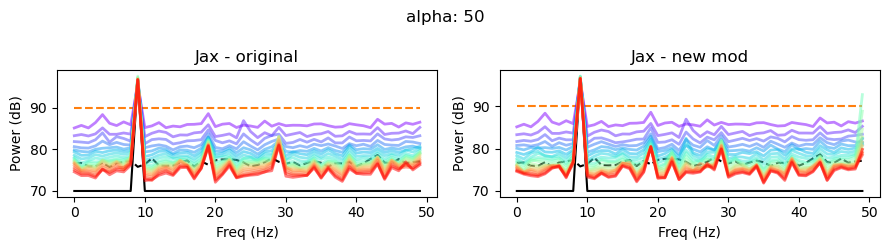

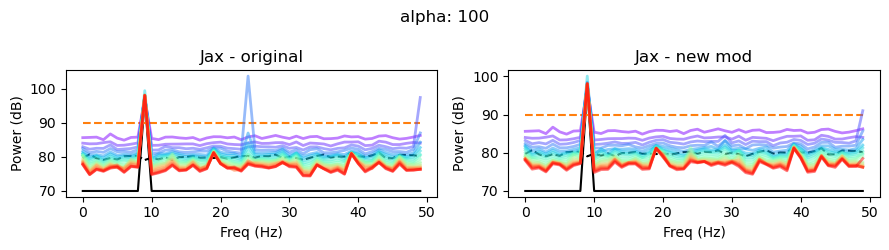

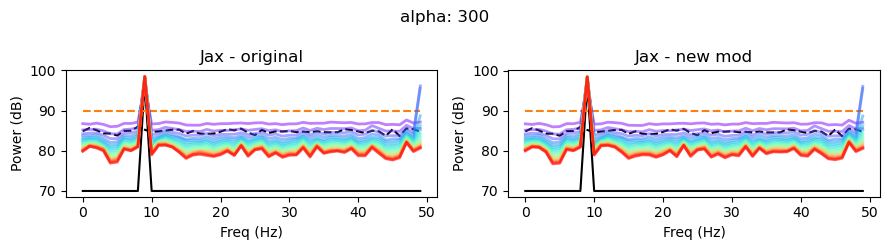

In [21]:
dB = True

if dB is True:
    transform = db_transform
else:
    transform = identity


for alpha in alphas:
# for alpha in [-3,-2,-1,0]:
    res_jax = res_load_conj_mod[alpha]
    gamma_naive = naive_ests[alpha]

    osel = {'alpha': alpha}
    res_jax_refac = filter_loaded(res_load_refac, {}, {}, osel)

    gamma_init = res_jax['gamma_init']
    gamma_true = res_jax['gamma_true_full'][nz,:,:]
    S_true = transform(gamma_true[:,k,k].real)
    S_init = transform(gamma_init[:,k,k].real)
    S_naive = transform(gamma_naive[:,k,k].real)

    fig, ax = plt.subplots(1,2, figsize=(9,2.5), sharex=True)
    fig.suptitle(f'alpha: {alpha}')
    ax[0].plot(S_true, 'k', label='True')
    ax[1].plot(S_true, 'k')
    # ax[2].plot(S_true, 'k')
    ax[0].plot(S_naive, '--', color='k', label='Naive')
    ax[1].plot(S_naive, '--', color='k')
    # ax[2].plot(S_naive, '--', color='k')
    ax[0].plot(S_init, '--', color='tab:orange', label='Init')
    ax[1].plot(S_init, '--', color='tab:orange')
    # ax[2].plot(S_init, '--', color='tab:orange')
    plot_spec_em_iters(ax[0], res_jax['track']['gamma'], k, dB=dB)
    ax[0].set_title('Jax - original')
    # plot_spec_em_iters(ax[1], scipy_oldmod_gamma_emtrack, k, dB=dB)
    # ax[1].set_title('Scipy')
    plot_spec_em_iters(ax[1], res_jax_refac['track'], k, dB=dB)
    ax[1].set_title('Jax - new mod')
    ax[0].set_xlabel('Freq (Hz)')
    ax[1].set_xlabel('Freq (Hz)')
    # ax[2].set_xlabel('Freq (Hz)')
    if dB is True:
        ylabel = 'Power (dB)'
    else:
        ylabel = "Power"
    ax[0].set_ylabel(ylabel)
    ax[1].set_ylabel(ylabel)
    # ax[2].set_ylabel(ylabel)
    # plot_spec_em_iters(ax[1], res_ts_oldmod_deconmod['track'].track_em_data['gamma'], k, dB=True)
    # plot_spec_em_iters(ax[1], res_ts_oldmod['track'].track_em_data['gamma'], k, dB=True)
    # plot_spec_em_iters(ax[1], scipy_old_gamma_emtrack, k, dB=True)
    # plot_spec_em_iters(ax[1], scipy_old_gamma_emtrack, k, dB=True)
    # plot_spec_em_iters(ax[2], scipy_oldmod_gamma_emtrack, k, dB=True)
    # ax[0].set_ylim([-10,5e8])
    # ax[1].set_ylim([-10,5e8])
    # ax[2].set_ylim([-20,120])

    plt.tight_layout()

In [23]:
delta = 1e-3
naive_ests = {}
for alpha in alphas:
    res = res_load_conj_mod[alpha]
    obs_a = sample_obs(gamma_full, res)
    ests_raw = jnp.fft.rfft(obs_a, axis=0)[1:,:,:]
    zs_est = ests_raw[nz,:,:]

    naive_est = jnp.einsum('nkl,nil->nkil', zs_est, zs_est.conj()).mean(-1) * 1e6
    
    naive_ests[alpha] = naive_est


In [24]:
def sample_lams(gamma, result):
   C = 1
   delta = 1e-3
   cfg = result['cfg']
   lcfg = cfg['latent']
   ocfg = cfg['obs']

   lrk = jr.key(lcfg.seed)
   ork = jr.key(ocfg.seed)
   L = lcfg.L
   alpha = ocfg.alpha

   zs = sample_from_gamma(lrk, gamma, L)
   zs_0dc = jnp.apply_along_axis(add0, 0, zs)
   xs = jnp.fft.irfft(zs_0dc, axis=0)

   K = xs.shape[1]
   if jnp.ndim(alpha) == 0:
      alphas = jnp.ones(K)*alpha
   else:
      assert alpha.ndim == 1
      assert alpha.size == K
      alphas = alpha
   lams_single = cif_alpha_relu(alphas, xs)
   lams = jnp.stack([lams_single for _ in range(C)], axis=1)

   return lams

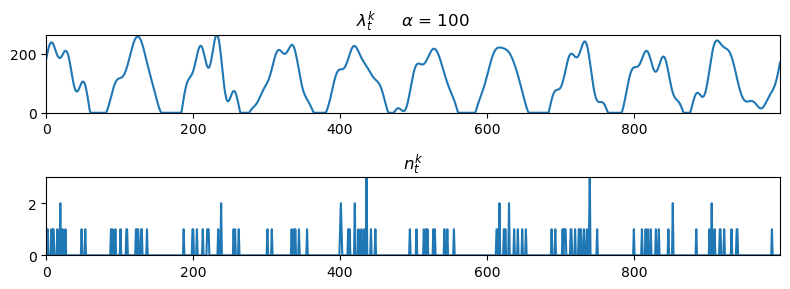

In [25]:
from cohlib.plot import draw_raster_single
alpha = 100
res = res_load_conj_mod[alpha]
gamma = res['gamma_true_full']
lams_a = sample_lams(gamma, res)
obs_a = sample_obs(gamma, res)

k = 0
l = 1
fig, ax = plt.subplots(2,1, figsize=(8,3))
ax[0].plot(lams_a[:,0,k,l])
ax[1].plot(obs_a[:,k,l])
ax[0].margins(0)
ax[1].margins(0)
ax[0].set_title(r'$\lambda^k_t$' + r'     $\alpha$' +  f' = {alpha}')
ax[1].set_title(r'$n^k_t$')
plt.tight_layout()

In [56]:
# look at cross-spec / different values compared to true for here and others 

In [63]:
from cohlib.mvcn import thr_coherence

def plot_cross_spec_em_iters(ax, gamma_iter_list, gamma_init, j_ind=9, nz=None):
    cs_real = jnp.array([gamma_init[j_ind,0,1].real] + [gamma_r[j_ind,0,1].real for gamma_r in gamma_iter_list])
    cs_imag = jnp.array([gamma_init[j_ind,0,1].imag] + [gamma_r[j_ind,0,1].imag for gamma_r in gamma_iter_list])
    ax.plot(cs_real, color='tab:blue', linewidth=2)
    ax.plot(cs_imag, color='tab:red', linewidth=2)

Returned single result.
Returned single result.
Returned single result.


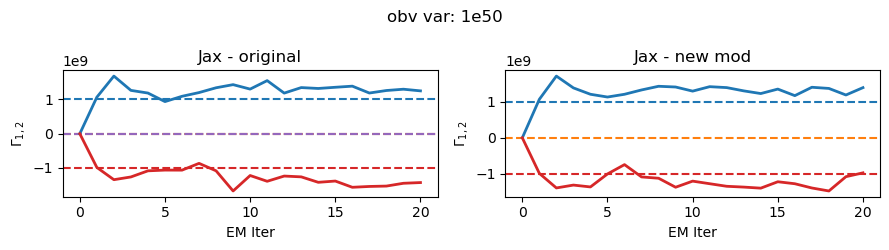

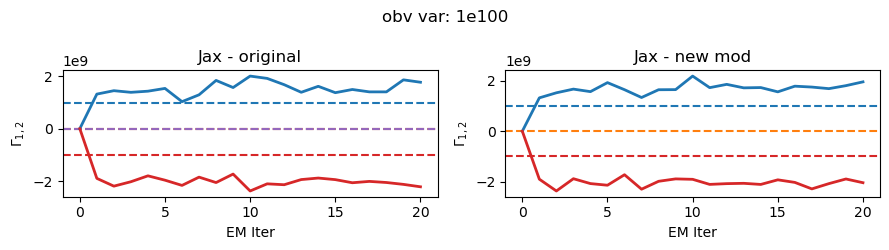

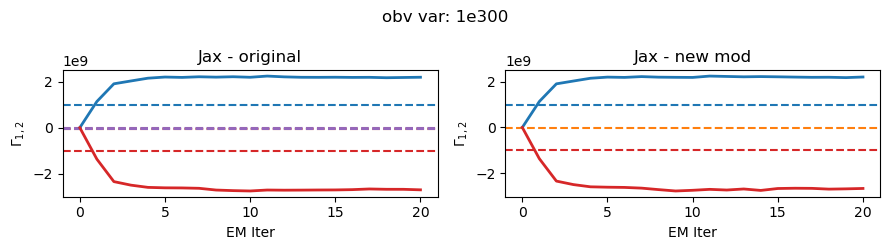

In [69]:
for alpha in alphas:
    res_jax = res_load_conj_mod[alpha]

    osel = {'alpha': alpha}
    res_jax_refac = filter_loaded(res_load_refac, {}, {}, osel)

    gamma_init = res_jax['gamma_init']
    gamma_true = res_jax['gamma_true_full'][nz,:,:]
    j_ind = 9
    S_true = thr_coherence(gamma_true)
    S_init = thr_coherence(gamma_init)

    gamma_naive = naive_ests[alpha]

    fig, ax = plt.subplots(1,2, figsize=(9,2.5), sharex=True)
    fig.suptitle(f'obv var: 1e{alpha}')
    ax[0].axhline(gamma_true[j_ind,0,1].real, linestyle='--', color='tab:blue')
    ax[0].axhline(gamma_naive[j_ind,0,1].real, linestyle='--', color='tab:purple')
    ax[1].axhline(gamma_true[j_ind,0,1].real, linestyle='--', color='tab:blue')
    ax[0].axhline(gamma_true[j_ind,0,1].imag, linestyle='--', color='tab:red')
    ax[0].axhline(gamma_naive[j_ind,0,1].imag, linestyle='--', color='tab:orange')
    ax[0].axhline(gamma_naive[j_ind,0,1].imag, linestyle='--', color='tab:purple')
    ax[1].axhline(gamma_true[j_ind,0,1].imag, linestyle='--', color='tab:red')
    ax[1].axhline(gamma_naive[j_ind,0,1].imag, linestyle='--', color='tab:orange')
    plot_cross_spec_em_iters(ax[0], res_jax['track']['gamma'], gamma_init, j_ind)
    ax[0].set_title('Jax - original')
    plot_cross_spec_em_iters(ax[1], res_jax_refac['track'], gamma_init, j_ind)
    ax[1].set_title('Jax - new mod')
    ax[0].set_xlabel('EM Iter')
    ax[1].set_xlabel('EM Iter')
    ylabel = r"$\Gamma_{1,2}$"
    ax[0].set_ylabel(ylabel)
    ax[1].set_ylabel(ylabel)

    # ax[0].set_ylim([-0.1,1])
    # ax[1].set_ylim([-0.1,1])
    # ax[2].set_ylim([-0.1,1])

    plt.tight_layout()

In [74]:
gamma_true.shape

(50, 2, 2)

In [ ]:
def plot_coh_em_iters(ax, gamma_iter_list, nz=None):
    if nz is None:
        nz = jnp.arange(gamma_iter_list[0].shape[0])
    num_iters = len(gamma_iter_list)
    color = plt.cm.rainbow(jnp.linspace(0, 1, num_iters))
    for r, c in enumerate(color): 
        gamma_r = gamma_iter_list[r]
        coh_r = thr_coherence(gamma_r[nz,:,:])
        ax.plot(coh_r, color=c, linewidth=2, alpha=0.5)

def plot_cross_spec_em_iters(ax, gamma_iter_list, gamma_init, j_ind=9, nz=None):
    cs_real = jnp.array([gamma_init[j_ind,0,1].real] + [gamma_r[j_ind,0,1].real for gamma_r in gamma_iter_list])
    cs_imag = jnp.array([gamma_init[j_ind,0,1].imag] + [gamma_r[j_ind,0,1].imag for gamma_r in gamma_iter_list])
    ax.plot(cs_real, color='tab:blue', linewidth=2)
    ax.plot(cs_imag, color='tab:red', linewidth=2)

def plot_coh_evol_em_iters(ax, gamma_iter_list, gamma_init, j_ind=9, nz=None):
    cs_real = jnp.array([gamma_init[j_ind,0,1].real] + [gamma_r[j_ind,0,1].real for gamma_r in gamma_iter_list])
    cs_imag = jnp.array([gamma_init[j_ind,0,1].imag] + [gamma_r[j_ind,0,1].imag for gamma_r in gamma_iter_list])
    ax.plot(cs_real, color='tab:blue', linewidth=2)
    ax.plot(cs_imag, color='tab:red', linewidth=2)

Returned single result.


TypeError: plot_coh_em_iters() takes from 2 to 3 positional arguments but 4 were given

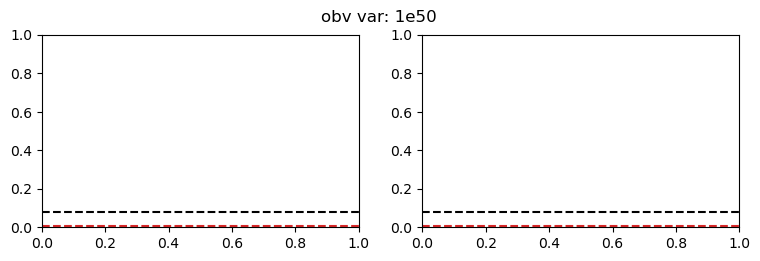

In [75]:
for alpha in alphas:
    res_jax = res_load_conj_mod[alpha]

    osel = {'alpha': alpha}
    res_jax_refac = filter_loaded(res_load_refac, {}, {}, osel)

    gamma_init = res_jax['gamma_init']
    gamma_true = res_jax['gamma_true_full'][nz,:,:]
    j_ind = 9
    coh_true = thr_coherence(gamma_true)[9]
    coh_init = thr_coherence(gamma_init)[9]

    gamma_naive = naive_ests[alpha]
    coh_naive = thr_coherence(gamma_naive)[9]

    fig, ax = plt.subplots(1,2, figsize=(9,2.5), sharex=True)
    fig.suptitle(f'obv var: 1e{alpha}')
    ax[0].axhline(coh_true, linestyle='--', color='k')
    ax[1].axhline(coh_true, linestyle='--', color='k')

    ax[0].axhline(coh_naive, linestyle='--', color='tab:red')
    ax[1].axhline(coh_naive, linestyle='--', color='tab:red')


    plot_coh_em_iters(ax[0], res_jax['track']['gamma'], gamma_init, j_ind)
    ax[0].set_title('Jax - original')
    plot_coh_em_iters(ax[1], res_jax_refac['track'], gamma_init, j_ind)
    ax[1].set_title('Jax - new mod')
    ax[0].set_xlabel('EM Iter')
    ax[1].set_xlabel('EM Iter')
    ylabel = r"$\Gamma_{1,2}$"
    ax[0].set_ylabel(ylabel)
    ax[1].set_ylabel(ylabel)

    # ax[0].set_ylim([-0.1,1])
    # ax[1].set_ylim([-0.1,1])
    # ax[2].set_ylim([-0.1,1])

    plt.tight_layout()

In [72]:
coh_true.shape

(50,)

In [66]:
naive_ests[alpha].shape

(50, 2, 2)